In [44]:
%pylab inline
import pandas as pd
import seaborn as sns
import json
from scipy.linalg import norm

sns.set_context('paper', font_scale=2)
sns.set_style('whitegrid')
np.random.seed(42)

Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e', 'sample', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df = pd.read_csv('data/wdbc.data', header=None)
df = df.drop(columns=[0])
output = np.array(df.loc[:, 1])
df  = df.drop(columns=[1])


In [3]:
df.shape

(569, 30)

In [4]:
df_matrix = df.as_matrix()

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [5]:
np.sum(df_matrix)

1056474.4596355997

# Normalize

In [6]:
df_normalized = df_matrix - df_matrix.mean()
df_normalized = df_normalized/np.sqrt((df_normalized * df_normalized).sum(axis=1))[:, np.newaxis]

In [7]:
df_normalized

array([[-0.01998381, -0.02344792,  0.02772619, ..., -0.02805213,
        -0.0279635 , -0.02811882],
       [-0.01797171, -0.01918952,  0.03088423, ..., -0.02683737,
        -0.02679866, -0.02687955],
       [-0.0208045 , -0.02003544,  0.03357715, ..., -0.03039166,
        -0.03033334, -0.03046828],
       ...,
       [-0.03326271, -0.02483149,  0.03408422, ..., -0.04535005,
        -0.04529129, -0.04539676],
       [-0.01915379, -0.01510415,  0.03627945, ..., -0.02858672,
        -0.02852006, -0.02865213],
       [-0.141273  , -0.09747973, -0.03646145, ..., -0.16152542,
        -0.16077614, -0.16134172]])

# Problem (a), (b)

In all of our experiments we will perform 100 random partitions of the data for
train/test and then report the final result as the average over these tria

\begin{align*}
(\hat{w}, \hat{b}) &= \text{arg} \min_{w,b} f(\vec{w}, b) := \frac{1}{N} \sum_{i=1}^N -y_i(\vec{w}^T\vec{x}_i + b) + \log(1+ \exp{(\vec{w}^T\vec{x}_i + b)} + \frac{\lambda^2}{2N} ||\vec{w}||_{l_2}^2
\end{align*}

Consider the derivatives:

\begin{align}
\frac{\partial f(\vec{w}, b)}{\partial b} &= \frac{1}{N} \sum_{i=1}^N -y_i + \frac{\exp{(\vec{w}^T\vec{x}_i + b)}}{1+ \exp{(\vec{w}^T\vec{x}_i + b)}}\\
&= \frac{1}{N} \sum_{i=1}^N \frac{1}{1+ \exp{(-(\vec{w}^T\vec{x}_i + b))}}-y_i
\end{align}

For $j \geq 1$ and learning rate $\mu$:

\begin{align}
\frac{\partial f(\vec{w}, b)}{\partial w_j} &= \frac{1}{N} \sum_{i=1}^N -y_i(x_j) + \frac{\exp{(\vec{w}^T\vec{x}_i + b)}}{1+ \exp{(\vec{w}^T\vec{x}_i + b)}}x_j + \frac{\lambda}{N} w_j\\ 
&=  \sum_{i=1}^N \big(\frac{1}{1+ \exp{(-(\vec{w}^T\vec{x}_i + b))}}-y_i\big)x_j + \frac{\lambda}{N}w_j
\end{align}

Gradient descent:

\begin{align*}
b^{(t+1)} &= b^{(t)} - \frac{\mu}{N} \sum_{i=1}^N \big(\frac{1}{1+ \exp{(-(\vec{w}^T\vec{x}_i + b))}}-y_i\big)\\
w^{(t+1)}_j &= w^{(t)}_j - \frac{\mu}{N} \sum_{i=1}^N \big(\frac{1}{1+ \exp{(-(\vec{w}^T\vec{x}_i + b))}}-y_i\big)x_{ij} + \frac{\lambda}{N}w_j^{(t)}\\
\end{align*}

where $x_{ij}$ refers to the $j^{th}$ feature of the $i^{th}$ sample. In our case.
$1 \leq j \leq 30$ and $i$ ranges over the number of samples.


This looks super confusing, let's resort to matrix notations., We construct an augmented matrix $X$ by appending a column of 1s in the beginning that will capture $b$.

$X = \begin{pmatrix}1 & x_{11} & x_{12} & \cdots & x_{1M}\\
1 & x_{21} & x_{22} & \cdots & x_{2M}\\
\vdots\\
1 & x_{N1} & x_{N2} & \cdots & x_{NM}\\
\end{pmatrix}_{N\times(M+1)}$

Our iteration vector is $\vec{w}_{1\times(M+1)} = \begin{pmatrix} b \\ w_1 \\ w_2 \\ \vdots \\ w_M \end{pmatrix}_{(M+1)\times 1}$, thus $X\vec{w}$ has dimensions $N \times 1$ which is same as our target vector $\vec{y}$

Let's also define an augmented  vector $\vec{v} = \begin{pmatrix} 0 \\ w_1 \\ w_2 \\ \vdots \\ w_M \end{pmatrix}_{(M+1)\times 1}$

And the update simplifies to:

\begin{align*}
\vec{w}_{(M+1)\times 1}^{(t+1)} &= \vec{w}^{(t+1)}_{(M+1)\times 1} - \frac{\mu}{N} X^T(X\vec{w}^{(t+1)}-\vec{y}) + \frac{\lambda}{M} \vec{v}^{t}
\end{align*}


In [122]:
def split_train_test(X, y, n_train=500):
    nrows = X.shape[0]
    indices = numpy.random.permutation(nrows)
    training_idx, test_idx = indices[:n_train], indices[n_train:]
    X_train, X_test = X[training_idx,:], X[test_idx,:]
    y_train, y_test = y[training_idx], y[test_idx]
    return (X_train, y_train, X_test, y_test)

def sigmoid(z):
    return 1/(1+np.exp(-z))


def calc_error(z, y_true):
    y_predicted = sigmoid(z)
    y_predicted[y_predicted>=0.5] = 1
    y_predicted[y_predicted<0.5] = 0
    return np.mean(np.abs(y_predicted-y_true))

def calc_misclassified(z, y_true):
    y_predicted = sigmoid(z)
    y_predicted[y_predicted>=0.5] = 1
    y_predicted[y_predicted<0.5] = 0
    return np.sum(np.abs(y_predicted-y_true))



def logistic_regression(X, y, 
                        X_test=None, 
                        y_test=None, 
                        num_steps=500, 
                        learning_rate=1e-6, 
                        regularizer_lambda=0.01):
    intercept = np.ones((X.shape[0], 1))
    X = np.hstack((intercept, X))
    if X_test is not None:
        intercept = np.ones((X_test.shape[0], 1))
        X_test= np.hstack((intercept, X_test))
    weights = np.zeros(X.shape[1])
    regularization_indicator = np.ones(X.shape[1])
    regularization_indicator[0] =  0
    regularization_weights = np.multiply(regularization_indicator, weights)
    training_errors = []
    training_misclassified = []
    testing_errors = []
    testing_misclassified = []
    error_ratios = []
    for step in range(num_steps):
        scores = np.dot(X, weights)
        predictions = sigmoid(scores)
        error = predictions - y
        gradient = np.dot(X.T, error)
        regularization_weights = np.multiply(regularization_indicator, weights)
        regularization = regularizer_lambda * regularization_weights

        weights = weights - (learning_rate * gradient) + regularization
        ll = log_likelihood(X, y, weights, regularizer_lambda)
        error_ratio = norm(gradient, 2)**2/(1+ll)
        error_ratios.append(error_ratio)

        if y_test is not None:
            scores_test = np.dot(X_test, weights)
            testing_error = calc_error(scores_test, y_test)
            testing_errors.append(testing_error)
            testing_misclassified.append(calc_misclassified(scores_test, y_test))
            
        training_error = calc_error(scores, y)
        training_errors.append(training_error)
        training_misclassified.append(calc_misclassified(scores, y))
        
    return weights, training_errors, testing_errors, training_misclassified, testing_misclassified, error_ratios

def log_likelihood(X, y, weights, regularizer_lambda):
    scores = np.dot(X, weights)
    ll = np.sum( -y*scores + np.log(1 + np.exp(scores)) ) + regularizer_lambda * norm(weights, 2)**2
    return ll

def logistic_regression_convergence(X, y, 
                                    X_test=None, 
                                    y_test=None, 
                                    max_error=1e-5, 
                                    learning_rate=1e-6, 
                                    regularizer_lambda=0.01,
                                    momentum=None,
                                    eta=0.1):
    intercept = np.ones((X.shape[0], 1))
    X = np.hstack((intercept, X))
    if X_test is not None:
        intercept = np.ones((X_test.shape[0], 1))
        X_test= np.hstack((intercept, X_test))
    weights = np.zeros(X.shape[1])
    regularization_indicator = np.ones(X.shape[1])
    regularization_indicator[0] =  0
    regularization_weights = np.multiply(regularization_indicator, weights)
    training_errors = []
    training_misclassified = []
    testing_errors = []
    testing_misclassified = []
    error_ratio = 1e5
    steps = 0
    weights_t = [weights]
    error_ratios = []
    while error_ratio > max_error:
        steps += 1
        scores = np.dot(X, weights)
        predictions = sigmoid(scores)
        error = predictions - y
        gradient = np.dot(X.T, error)
        regularization_weights = np.multiply(regularization_indicator, weights)
        regularization = regularizer_lambda * regularization_weights

        if momentum is None:
            weights = weights - (learning_rate * gradient) + regularization
        elif momentum is 'heavy_ball':
            old_weights = weights.copy()
            if steps>=2:
                weights = weights - (learning_rate * gradient) + regularization +\
                eta * (weights_t[steps-1]-weights_t[steps-2])
            else:
                weights = weights - (learning_rate * gradient) + regularization 
        elif momentum is 'nesterov':            
            if steps>=2:
                scores = np.dot(X, weights+eta*(weights_t[steps-1]-weights_t[steps-2]))
                predictions = sigmoid(scores)
                error = predictions - y
                gradient = np.dot(X.T, error)
                regularization_weights = np.multiply(regularization_indicator, weights)
                regularization = regularizer_lambda * regularization_weights
                weights = weights - (learning_rate * gradient) + regularization +\
                eta * (weights_t[steps-1]-weights_t[steps-2])
            else:
                weights = weights - (learning_rate * gradient) + regularization 
            
        weights_t.append(weights)
        ll = log_likelihood(X, y, weights, regularizer_lambda)
        error_ratio = norm(gradient, 2)**2/(1+ll)
        error_ratios.append(error_ratio)
        if y_test is not None:
            scores_test = np.dot(X_test, weights)
            testing_error = calc_error(scores_test, y_test)
            testing_errors.append(testing_error)
            testing_misclassified.append(calc_misclassified(scores_test, y_test))
            
        training_error = calc_error(scores, y)
        training_errors.append(training_error)
        training_misclassified.append(calc_misclassified(scores, y))
        
    return weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios

In [95]:
def logistic_regression_convergence_steps(X, y, 
                                          X_test=None, 
                                          y_test=None, 
                                          max_steps=500, 
                                          learning_rate=1e-6, 
                                          regularizer_lambda=0.01,
                                          momentum=None,
                                          eta=0.1):
    intercept = np.ones((X.shape[0], 1))
    X = np.hstack((intercept, X))
    if X_test is not None:
        intercept = np.ones((X_test.shape[0], 1))
        X_test= np.hstack((intercept, X_test))
    weights = np.zeros(X.shape[1])
    regularization_indicator = np.ones(X.shape[1])
    regularization_indicator[0] =  0
    regularization_weights = np.multiply(regularization_indicator, weights)
    training_errors = []
    training_misclassified = []
    testing_errors = []
    testing_misclassified = []
    error_ratio = 1e5
    steps = 0
    weights_t = [weights]
    error_ratios = []

    while steps < max_steps:
        steps += 1
        scores = np.dot(X, weights)
        predictions = sigmoid(scores)
        error = predictions - y
        gradient = np.dot(X.T, error)
        regularization_weights = np.multiply(regularization_indicator, weights)
        regularization = regularizer_lambda * regularization_weights

        if momentum is None:
            weights = weights - (learning_rate * gradient) + regularization
        elif momentum is 'heavy_ball':
            old_weights = weights.copy()
            if steps>=2:
                weights = weights - (learning_rate * gradient) + regularization +\
                eta * (weights_t[steps-1]-weights_t[steps-2])
            else:
                weights = weights - (learning_rate * gradient) + regularization 
        elif momentum is 'nesterov':            
            if steps>=2:
                scores = np.dot(X, weights+eta*(weights_t[steps-1]-weights_t[steps-2]))
                predictions = sigmoid(scores)
                error = predictions - y
                gradient = np.dot(X.T, error)
                regularization_weights = np.multiply(regularization_indicator, weights)
                regularization = regularizer_lambda * regularization_weights
                weights = weights - (learning_rate * gradient) + regularization +\
                eta * (weights_t[steps-1]-weights_t[steps-2])
            else:
                weights = weights - (learning_rate * gradient) + regularization 
            
        weights_t.append(weights)
        ll = log_likelihood(X, y, weights, regularizer_lambda)
        error_ratio = norm(gradient, 2)**2/(1+ll)
        error_ratios.append(error_ratio)
        if y_test is not None:
            scores_test = np.dot(X_test, weights)
            testing_error = calc_error(scores_test, y_test)
            testing_errors.append(testing_error)
            testing_misclassified.append(calc_misclassified(scores_test, y_test))
            
        training_error = calc_error(scores, y)
        training_errors.append(training_error)
        training_misclassified.append(calc_misclassified(scores, y))
        
    return weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios

In [9]:

X_train = []
y_train = []

X_test = []
y_test = []

N_iter = 100
lamda_w = 0.01
T = 500

for i in range(N_iter):
    train_x, train_label, test_x, test_label = split_train_test(df_normalized, output)
    X_train.append(train_x)
    y_train.append(train_label)
    X_test.append(test_x)
    y_test.append(test_label)



# Problem (c)
Now that we have normalized data, partition it into train/test sets at random 100 times
as discussed earlier. In each trial learn the model by solving (1) with λ = 0.01. To
due this run gradient descent for T = 500 iterations and then use the trained model to
make predictions on the test data and calculate the average error (average number of
miss-classified patients on the test data) for each trial. Report the average over the 100
trials. The value of the step size you use does not matter too much. However, make sure
that the algorithm has converged

In [123]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []

for i in range(100):
    weights, training_errors, testing_errors, training_misclassified, testing_misclassified, error_ratios = logistic_regression(X_train[i], 
                                                                                                                  y_train[i], 
                                                                                                                  X_test[i], 
                                                                                                                  y_test[i], 
                                                                                                                  num_steps=500, 
                                                                                                                  learning_rate=0.01,
                                                                                                                  regularizer_lambda=0.01)
    all_weights.append(weights)
    all_training_errors.append(training_errors)
    all_testing_errors.append(testing_errors)
    all_training_misclassified.append(training_misclassified)
    all_testing_misclassified.append(testing_misclassified)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [19]:
vanilla_logistic = {'weights': all_weights,
                    'training_errors': all_training_errors,
                    'testing_errors': all_testing_errors,
                    'training_misclassified': all_training_misclassified,
                    'testing_misclassified': all_testing_misclassified
                   }

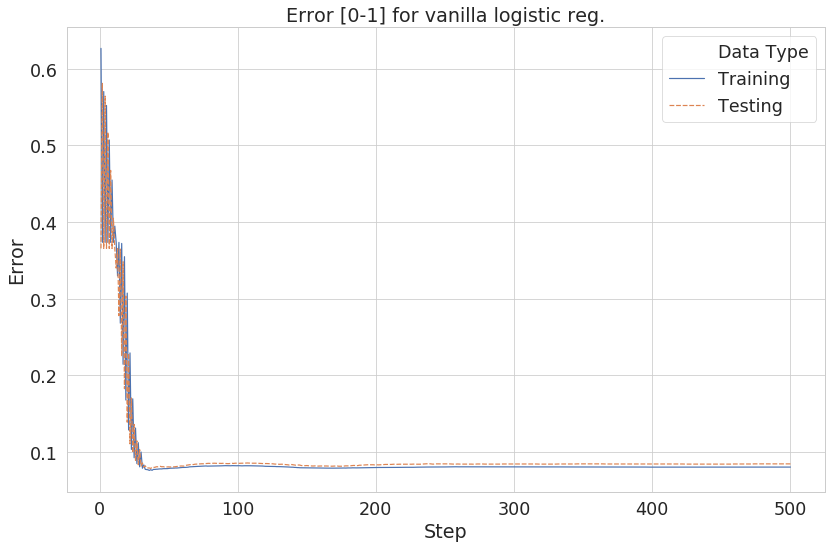

In [109]:
vanilla_df = []
for index, error in enumerate(vanilla_logistic['training_errors']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Training'])
for index, error in enumerate(vanilla_logistic['testing_errors']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Testing'])
vanilla_df = pd.DataFrame(vanilla_df, columns=['sample', 'Error', 'Step', 'Data Type'])
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="Step",
             y="Error",
             hue="Data Type",
             style="Data Type",
             markers=False,
             dashes=True, 
             err_style="bars",
             ci=None,
             data=vanilla_df,
             ax=ax)
ax.set_title('Error [0-1] for vanilla logistic reg.')
fig.tight_layout()
fig.savefig('vanilla_error.pdf')

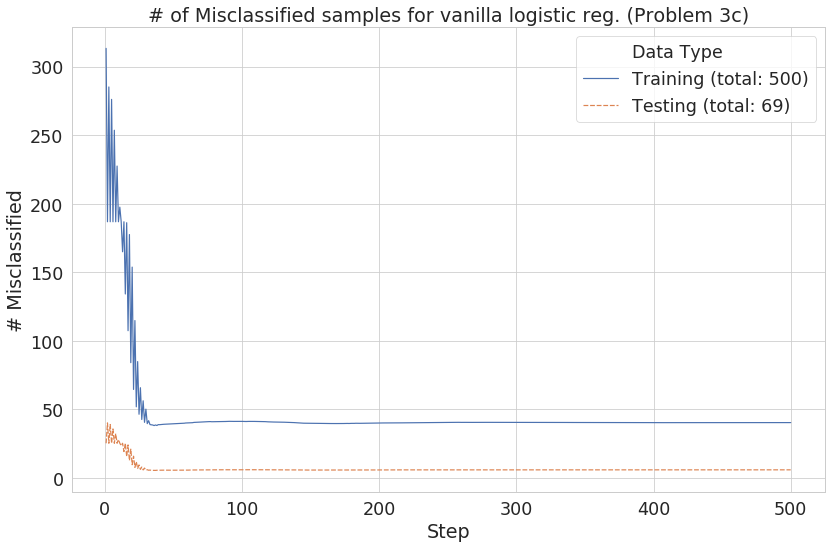

In [108]:
vanilla_df = []
for index, error in enumerate(vanilla_logistic['training_misclassified']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Training (total: 500)'])
for index, error in enumerate(vanilla_logistic['testing_misclassified']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Testing (total: 69)'])
vanilla_df = pd.DataFrame(vanilla_df, columns=['sample', "# Misclassified", 'Step', 'Data Type'])

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="Step",
             y="# Misclassified",
             hue="Data Type",
             style="Data Type",
             markers=False,
             dashes=True, 
             err_style="bars",
             ci=None,
             data=vanilla_df,
             ax=ax)
ax.set_title('# of Misclassified samples for vanilla logistic reg. (Problem 3c)')
fig.tight_layout()

fig.savefig('vanilla_testing_misclassified.pdf')

# Problem (d)

Perform the experiment with the same step size you used before but now report the
number of iterations it takes to get to an accuracy of 10−6
calculated via the first iteration t when the following inequality holds
$||f(w_t, b_t)||^2_{l_2} \leq 10^{−6}(1 + |f(w_t, b_t)|)$

The number you should report is the average of this number over the 100 trials

In [22]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_steps = []
all_error_ratios = []
for i in range(100):
    weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios = logistic_regression_convergence(X_train[i], 
                                                                                                                                     y_train[i], 
                                                                                                                                     X_test[i], 
                                                                                                                                     y_test[i], 
                                                                                                                                     max_error=1e-5, 
                                                                                                                                     learning_rate=0.1,
                                                                                                                                     regularizer_lambda=0.01)
    
    
    
    
    all_weights.append(weights)
    all_training_errors.append(training_errors)
    all_testing_errors.append(testing_errors)
    all_training_misclassified.append(training_misclassified)
    all_testing_misclassified.append(testing_misclassified)
    all_steps.append(steps)
    all_error_ratios.append(error_ratios)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [25]:
steps_logistic = {'weights': all_weights,
                  'training_errors': all_training_errors,
                  'testing_errors': all_testing_errors,
                  'training_misclassified': all_training_misclassified,
                  'testing_misclassified': all_testing_misclassified,
                  'steps': all_steps
                 }

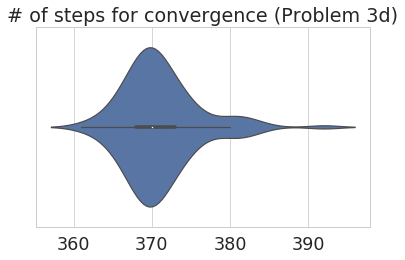

In [68]:
fig = plt.figure()
ax = sns.violinplot(steps_logistic['steps'])
ax.set_title('# of steps for convergence (Problem 3d)')
fig.tight_layout()
fig.savefig('number_of_steps_3d.pdf')


# Problem (e)

Perform the experiment of part (d) but now add a momentum term (1) using the heavy
ball method and (2) using Nesterov’s accelerated scheme. In both cases keep the same
step size as part (d) but fine tune the momentum parameter to get the smallest number
of iterations for convergence based on the stopping criteria (2) (again averaged over the
100 trials). Draw the convergence of the three algorithms gradient descent, heavy ball,
Nesterov’s accelerated scheme for one trial. That is, draw the ratio
k∇f(wt, bt)k2`2(1 + |f(wt, bt)|) as a function of the iteration number t = 1, 2, . . . , 500. Which algorithm would you use
and why

In [83]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_error_ratios = []
min_steps = 1e5
for eta in np.linspace(0.0, 1, 20):
    all_steps = []
    for i in range(100):
        
        weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios = logistic_regression_convergence(X_train[i], 
                                                                                                                                     y_train[i], 
                                                                                                                                     X_test[i], 
                                                                                                                                     y_test[i], 
                                                                                                                                     max_error=1e-5, 
                                                                                                                                     learning_rate=0.1,
                                                                                                                                     regularizer_lambda=0.01,
                                                                                                                                     momentum='heavy_ball',
                                                                                                                                     eta=eta)
        all_steps.append(steps)
    if np.mean(all_steps) < min_steps:
        min_steps = np.mean(all_steps)
        opt_eta_heavy_ball = eta

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [84]:
opt_eta_heavy_ball

1.0

In [110]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_steps = []
all_error_ratios = []
for i in range(100):
    weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios = logistic_regression_convergence(X_train[i], 
                                                                                                                                 y_train[i], 
                                                                                                                                 X_test[i], 
                                                                                                                                 y_test[i], 
                                                                                                                                 max_error=1e-5, 
                                                                                                                                 learning_rate=0.1,
                                                                                                                                 regularizer_lambda=0.01,
                                                                                                                                 momentum='heavy_ball',
                                                                                                                                 eta=opt_eta_heavy_ball)
    all_weights.append(weights)
    all_training_errors.append(training_errors)
    all_testing_errors.append(testing_errors)
    all_training_misclassified.append(training_misclassified)
    all_testing_misclassified.append(testing_misclassified)
    all_steps.append(steps)
    all_error_ratios.append(error_ratios)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [111]:
heavy_ball_logistic = {'weights': all_weights,
                       'training_errors': all_training_errors,
                       'testing_errors': all_testing_errors,
                       'training_misclassified': all_training_misclassified,
                       'testing_misclassified': all_testing_misclassified,
                       'steps': all_steps,
                       'error_ratios': all_error_ratios,
                       'opt_eta': opt_eta_heavy_ball
                      }

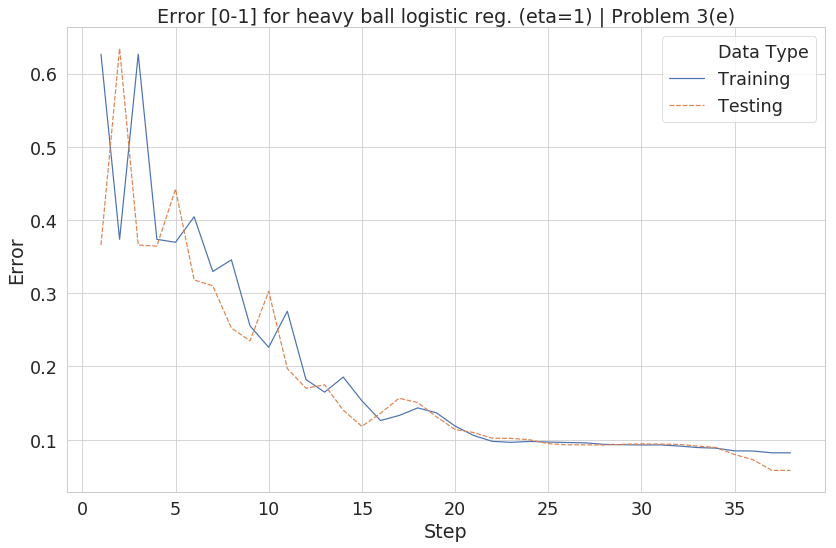

In [112]:
vanilla_df = []
for index, error in enumerate(heavy_ball_logistic['training_errors']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Training'])
for index, error in enumerate(heavy_ball_logistic['testing_errors']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Testing'])
vanilla_df = pd.DataFrame(vanilla_df, columns=['sample', 'Error', 'Step', 'Data Type'])
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="Step",
             y="Error",
             hue="Data Type",
             style="Data Type",
             markers=False,
             dashes=True, 
             err_style="bars",
             ci=None,
             data=vanilla_df,
             ax=ax)
ax.set_title('Error [0-1] for heavy ball logistic reg. (eta=1) | Problem 3(e)')
fig.tight_layout()
fig.savefig('heavy_ball_opt_error.pdf')

In [91]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_error_ratios = []
min_steps = 1e5
for eta in np.linspace(0.0, 1, 20):
    all_steps = []
    for i in range(100):
        
        weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios = logistic_regression_convergence(X_train[i], 
                                                                                                                                     y_train[i], 
                                                                                                                                     X_test[i], 
                                                                                                                                     y_test[i], 
                                                                                                                                     max_error=1e-5, 
                                                                                                                                     learning_rate=0.1,
                                                                                                                                     regularizer_lambda=0.01,
                                                                                                                                     momentum='nesterov',
                                                                                                                                     eta=eta)
        all_steps.append(steps)
    if np.mean(all_steps) < min_steps:
        min_steps = np.mean(all_steps)
        opt_eta_nesterov = eta

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [113]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_steps = []
all_error_ratios = []
for i in range(100):
    weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios = logistic_regression_convergence(X_train[i], 
                                                                                                                                 y_train[i], 
                                                                                                                                 X_test[i], 
                                                                                                                                 y_test[i], 
                                                                                                                                 max_error=1e-5, 
                                                                                                                                 learning_rate=0.1,
                                                                                                                                 regularizer_lambda=0.01,
                                                                                                                                 momentum='nesterov',
                                                                                                                                 eta=opt_eta_nesterov)
    all_weights.append(weights)
    all_training_errors.append(training_errors)
    all_testing_errors.append(testing_errors)
    all_training_misclassified.append(training_misclassified)
    all_testing_misclassified.append(testing_misclassified)
    all_steps.append(steps)
    all_error_ratios.append(error_ratios)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [114]:
nesterov_logistic = {'weights': all_weights,
                     'training_errors': all_training_errors,
                     'testing_errors': all_testing_errors,
                     'training_misclassified': all_training_misclassified,
                     'testing_misclassified': all_testing_misclassified,
                     'steps': all_steps,
                     'error_ratios': all_error_ratios,
                     'opt_eta': opt_eta_nesterov
                    }

In [115]:
opt_eta_nesterov

1.0

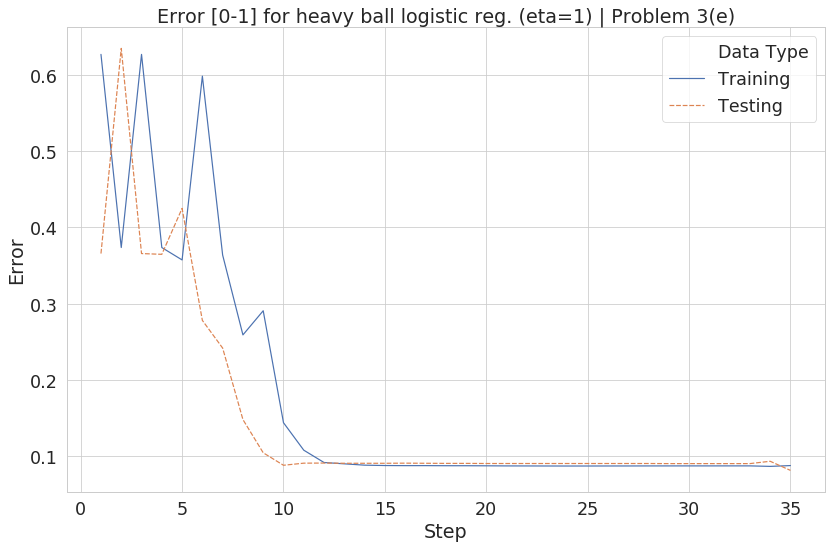

In [116]:
vanilla_df = []
for index, error in enumerate(nesterov_logistic['training_errors']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Training'])
for index, error in enumerate(nesterov_logistic['testing_errors']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Testing'])
vanilla_df = pd.DataFrame(vanilla_df, columns=['sample', 'Error', 'Step', 'Data Type'])
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="Step",
             y="Error",
             hue="Data Type",
             style="Data Type",
             markers=False,
             dashes=True, 
             err_style="bars",
             ci=None,
             data=vanilla_df,
             ax=ax)
ax.set_title('Error [0-1] for heavy ball logistic reg. (eta=1) | Problem 3(e)')
fig.tight_layout()
fig.savefig('nesterov_opt_error.pdf')

# For 500 steps

In [118]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_steps = []
all_error_ratios = []
for i in range(100):
    weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios = logistic_regression_convergence_steps(X_train[i], 
                                                                                                                                 y_train[i], 
                                                                                                                                 X_test[i], 
                                                                                                                                 y_test[i], 
                                                                                                                                 max_steps=500, 
                                                                                                                                 learning_rate=0.1,
                                                                                                                                 regularizer_lambda=0.01,
                                                                                                                                 momentum='nesterov',
                                                                                                                                 eta=opt_eta_nesterov)
    all_weights.append(weights)
    all_training_errors.append(training_errors)
    all_testing_errors.append(testing_errors)
    all_training_misclassified.append(training_misclassified)
    all_testing_misclassified.append(testing_misclassified)
    all_steps.append(steps)
    all_error_ratios.append(error_ratios)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [119]:
nesterov_logistic_steps = {'weights': all_weights,
                           'training_errors': all_training_errors,
                           'testing_errors': all_testing_errors,
                           'training_misclassified': all_training_misclassified,
                           'testing_misclassified': all_testing_misclassified,
                           'steps': all_steps,
                           'error_ratios': all_error_ratios,
                           'opt_eta': opt_eta_nesterov
                    }

In [120]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_steps = []
all_error_ratios = []
for i in range(100):
    weights, training_errors, testing_errors, training_misclassified, testing_misclassified, steps, error_ratios = logistic_regression_convergence_steps(X_train[i], 
                                                                                                                                 y_train[i], 
                                                                                                                                 X_test[i], 
                                                                                                                                 y_test[i], 
                                                                                                                                 max_steps=500, 
                                                                                                                                 learning_rate=0.1,
                                                                                                                                 regularizer_lambda=0.01,
                                                                                                                                 momentum='heavy_ball',
                                                                                                                                 eta=opt_eta_heavy_ball)
    all_weights.append(weights)
    all_training_errors.append(training_errors)
    all_testing_errors.append(testing_errors)
    all_training_misclassified.append(training_misclassified)
    all_testing_misclassified.append(testing_misclassified)
    all_steps.append(steps)
    all_error_ratios.append(error_ratios)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [121]:
heavy_ball_logistic_steps = {'weights': all_weights,
                           'training_errors': all_training_errors,
                           'testing_errors': all_testing_errors,
                           'training_misclassified': all_training_misclassified,
                           'testing_misclassified': all_testing_misclassified,
                           'steps': all_steps,
                           'error_ratios': all_error_ratios,
                           'opt_eta': opt_eta_nesterov
                    }

In [124]:
all_weights = []
all_training_errors = []
all_testing_errors = []
all_training_misclassified = []
all_testing_misclassified = []
all_error_ratios = []
for i in range(100):
    weights, training_errors, testing_errors, training_misclassified, testing_misclassified, error_ratios = logistic_regression(X_train[i], 
                                                                                                                  y_train[i], 
                                                                                                                  X_test[i], 
                                                                                                                  y_test[i], 
                                                                                                                  num_steps=500, 
                                                                                                                  learning_rate=0.01,
                                                                                                                  regularizer_lambda=0.01)
    all_weights.append(weights)
    all_training_errors.append(training_errors)
    all_testing_errors.append(testing_errors)
    all_training_misclassified.append(training_misclassified)
    all_testing_misclassified.append(testing_misclassified)
    all_error_ratios.append(error_ratios)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [125]:
vanilla_logistic_steps = {'weights': all_weights,
                           'training_errors': all_training_errors,
                           'testing_errors': all_testing_errors,
                           'training_misclassified': all_training_misclassified,
                           'testing_misclassified': all_testing_misclassified,
                           'error_ratios': all_error_ratios,
                    }

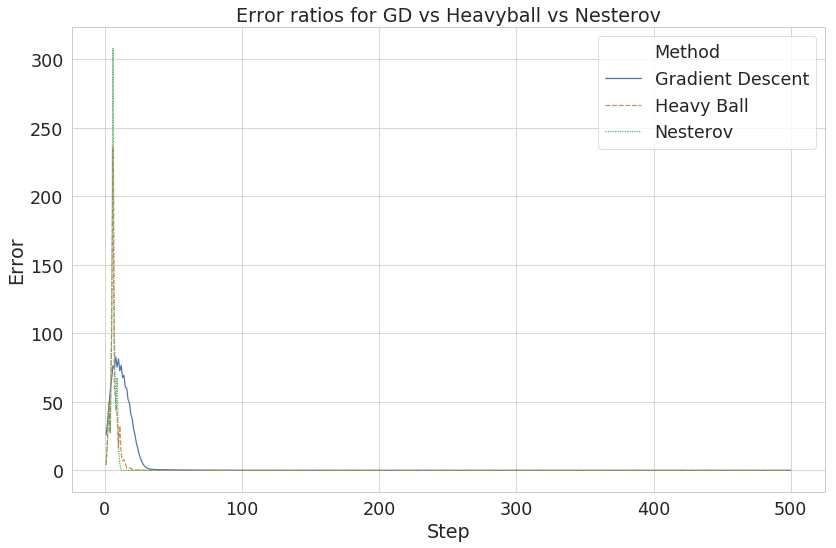

In [127]:
vanilla_df = []
for index, error in enumerate(vanilla_logistic_steps['error_ratios']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Gradient Descent'])
for index, error in enumerate(heavy_ball_logistic_steps['error_ratios']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Heavy Ball'])
for index, error in enumerate(nesterov_logistic_steps['error_ratios']):
    sample = 's{}'.format(index)
    for t, e in enumerate(error):
        vanilla_df.append([sample, e, t+1, 'Nesterov'])
        
vanilla_df = pd.DataFrame(vanilla_df, columns=['sample', 'Error', 'Step', 'Method'])
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="Step",
             y="Error",
             hue="Method",
             style="Method",
             markers=False,
             dashes=True, 
             err_style="bars",
             ci=None,
             data=vanilla_df,
             ax=ax)
ax.set_title('Error ratios for GD vs Heavyball vs Nesterov')
fig.tight_layout()
fig.savefig('error_ratios_gd_vs_h_vs_n.pdf')

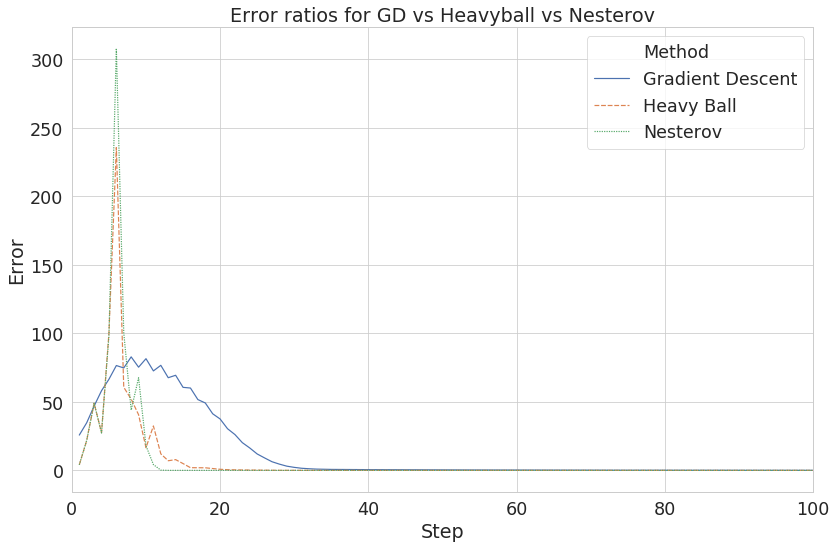

In [128]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="Step",
             y="Error",
             hue="Method",
             style="Method",
             markers=False,
             dashes=True, 
             err_style="bars",
             ci=None,
             data=vanilla_df,
             ax=ax)
ax.set_xlim(0,100)
ax.set_title('Error ratios for GD vs Heavyball vs Nesterov')
fig.tight_layout()
fig.savefig('error_ratios_gd_vs_h_vs_n_100.pdf')